In [63]:
import scipy.stats as staty
import numpy.linalg as LA
import numpy as np
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
temp_lj = pd.read_csv('Temp_LJ.csv')
temp_lj

,LETO,MESEC,TEMPERATURA
0,1986,1,0.1
1,1986,2,-2.8
2,1986,3,3.2
3,1986,4,10.2
4,1986,5,17.6
...,...,...,...
415,2020,8,22.2
416,2020,9,17.5
417,2020,10,11.9
418,2020,11,5.3


V datoteki Temp LJ se nahajajo izmerjene mesečne temperature v Ljubljani v 
letih od 1986 do 2020. Postavimo naslednja dva modela spreminjanja temperature
s časom: 

    - Model A: vključuje linearni trend in sinusno nihanje s periodo eno 
        leto.
    - Model B: vključuje linearni trend in spreminjanje temperature za 
        vsak mesec posebej.

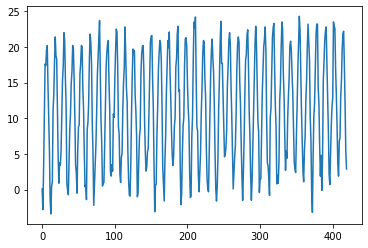

In [64]:
plt.plot(temp_lj['TEMPERATURA'])

(9.056666666666667, 13.273750000000005)

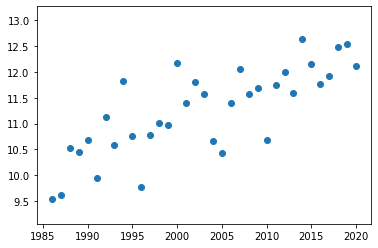

In [65]:
T = temp_lj['TEMPERATURA']
cas = temp_lj["LETO"]
leta = [cas[i] for i in range(420) if i % 12 == 0]
casPlot = np.array(leta)
T_leta = [np.average(T[k*12:(k+1)*12]) for k in range(35)]
Tplot = np.array(T_leta)
plt.scatter(casPlot, Tplot)
plt.ylim(min(Tplot)*0.95, 1.05*max(Tplot))

0.06463585434173644, -118.20894957983138


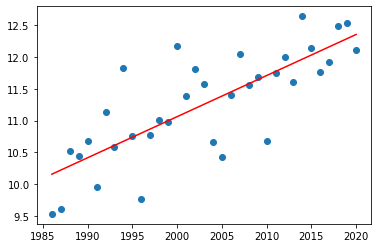

In [66]:
A = np.vstack([leta, np.ones(len(leta))]).T
result = LA.lstsq(A, T_leta, rcond=None)
k, n = result[0]
print(str(k) +', ' + str(n))
premica = [leta[i]*k + n for i in range(len(leta))]
plt.scatter(casPlot, Tplot)
plt.plot(casPlot, premica, 'r')

In [67]:
result

(array([ 6.46358543e-02, -1.18208950e+02]),
 array([9.34622106]),
 2,
 array([1.18500599e+04, 2.98296106e-02]))

a) Preizkusite model A znotraj modela B.

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big)$$

([<matplotlib.axis.XTick at 0x1f9aac75d68>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

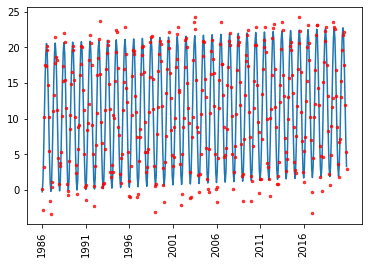

In [137]:
L = 420
leta = np.array([1986 + i//12 for i in range(420)])
leta = temp_lj["LETO"].values
enice = np.ones(L)
meseci = np.array([(1 + i%12) for i in range (420)])
sin_meseci = np.sin(meseci*np.pi/6)
cos_meseci = np.cos(meseci*np.pi/6)
M = np.array([leta,
             enice,
             sin_meseci,
             cos_meseci])
temperature = np.array(temp_lj['TEMPERATURA'])
result = LA.lstsq(M.T, temperature, rcond=None)

a, b, c, d = result[0]
model_A = [a*leta[l] + b + c*sin_meseci[l] + d*cos_meseci[l] for l in range(L)]
plt.plot(np.arange(420), model_A)
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')


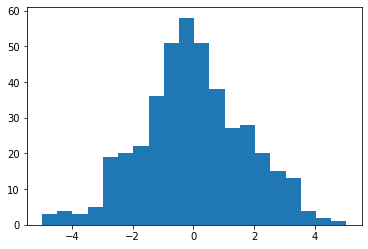

In [151]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)

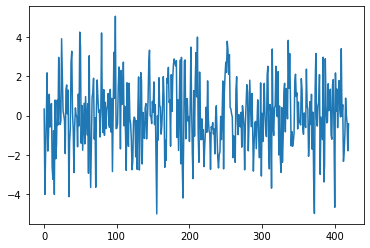

In [152]:
plt.plot(residual)

In [156]:
a - 0.06463585434173644

-4.066191827689636e-15

b) Pri modeliranju je nevarno privzeti preširok model: lahko bi recimo postavili
model, po katerem je temperatura vsak mesec drugačna, neidvisno od ostalih
mesecev, a tak model bi bil neuporaben za napovedovanje. Akaikejeva 
informacija nam pomaga poiskati optimalni model – izberemo tistega, za katerega
je le-ta najmanjša. Akaikejeva informacija je sicer definirana z verjetjem, 
a pri linearni regresiji in Gaussovem modelu je le-ta ekvivalentna naslednji 
modifikaciji:  
$$\text{AIC} := 2m + n \ln \text{RSS,}
$$
kjer je m število parametrov, n pa je število opažanj. Kateri od zgornjih dveh
modelov ima manjšo Akaikejevo informacijo?